# Covid-19 Data Cleaning

Preprocessing for the covid-19 statistics project. This notebook includes a detailed discussion of the invalid values in some fields in order to judge how to properly handle these values. 

**Associated links**
- [Main notebook](https://nbviewer.jupyter.org/github/apalermo01/covid-19-data-analysis/blob/main/Covid-19%20data%20analysis.ipynb)
- [Github repo](https://github.com/apalermo01/covid-19-data-analysis)

In [1]:
# configure settings
%reset -f
%config InlineBackend.figure_format = 'svg'


import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns
from tabulate import tabulate
from IPython.display import clear_output

import us

# fontsizes for plots
BIG_TEXT   = 18
MED_TEXT   = 14
SMALL_TEXT = 10

Load the dataset of new COVID-19 cases and deaths

In [2]:
df = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df.head()

,uid,location_type,fips_code,location_name,state,date,total_population,cumulative_cases,cumulative_cases_per_100_000,cumulative_deaths,cumulative_deaths_per_100_000,new_cases,new_deaths,new_cases_per_100_000,new_deaths_per_100_000,new_cases_7_day_rolling_avg,new_deaths_7_day_rolling_avg
0,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-22,18181.0,0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-23,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-24,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-25,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,63072001,county,72001.0,Adjuntas,Puerto Rico,2020-01-26,18181.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


Check the distribution of numerical fields, number of nulls in each column, and the datatypes present in each column. df.info() gives similar information, however it's presented in terms on non-null datapoints and non-numeric datatypes seem to be cast to object. We'll define our own function to do something similar, except this will count the number of null values and list all the datatypes present in each column.

In [3]:
def eval_df(df):
    table = []
    for col in df.columns: 
        table.append([col, df[col].isnull().sum(), set([type(i) for i in df[col].values])])
    print(tabulate(table, headers=["field", "num_nulls", "datatypes"]))
eval_df(df)

field                            num_nulls  datatypes
-----------------------------  -----------  --------------------------------
uid                                      0  {<class 'numpy.int64'>}
location_type                            0  {<class 'str'>}
fips_code                             3360  {<class 'numpy.float64'>}
location_name                          672  {<class 'float'>, <class 'str'>}
state                                    0  {<class 'str'>}
date                                     0  {<class 'str'>}
total_population                     38976  {<class 'numpy.float64'>}
cumulative_cases                         0  {<class 'numpy.int64'>}
cumulative_cases_per_100_000         38976  {<class 'numpy.float64'>}
cumulative_deaths                        0  {<class 'numpy.int64'>}
cumulative_deaths_per_100_000        38976  {<class 'numpy.float64'>}
new_cases                             3336  {<class 'numpy.float64'>}
new_deaths                            3336  {<class 'numpy

On first look, we see several issues with this dataset: 

1) some column names are particularly long, so we'll rename them

2) some columns contain null values

3) we need to check that columns with the *object* datatype are the correct type (i.e. strings)
    
4) fips_code and total_population are expected to be integers

begin by renaming certain columns

In [4]:
df.rename(columns={
    'cumulative_cases_per_100_000': 'cumulative_cases_1e6', 
    'cumulative_deaths_per_100_000': 'cumulative_deaths_1e6',
    'new_cases_per_100_000': 'new_cases_1e6', 
    'new_deaths_per_100_000': 'new_deaths_1e6', 
    'new_cases_7_day_rolling_avg': 'new_cases_7day', 
    'new_deaths_7_day_rolling_avg': 'new_deaths_7day'
    
}, inplace=True)

Summary of columns and expected data types

| column | details | accepted values |
|-----|------|--------|
| uid | Unique location identifier | numpy.int64
| location_type | type of location data | string
| fips_code | Federal Information Processing System code for each location | 5 digit integer
| location_name | location name | string
| state | state name | string
| date | date of record | datetime object
| total_population | county population | positive integer
| cumulative_cases | total number of covid cases | positive integer
| cumulative_cases_1e6 | normalized total covid cases | positive float
| cumulative_deaths | total number of covid deaths | positive integer
| cumulative_deaths_1e6 | normalized total covid deaths | positive float
| new_cases | number of new covid cases | positive integer
| new_deaths | number of new covid deaths | positive integer
| new_cases_1e6 | normalized number of new cases | positive float
| new_deaths_1e6 | normalized number of new deaths | positive float
| new_cases_7day | 7 day average of new cases | positive float
| new_deaths_7day | 7 day average of new deaths | positive float


Count the number of nulls in each column

Let's get a more visual description of how these nulls are distributed

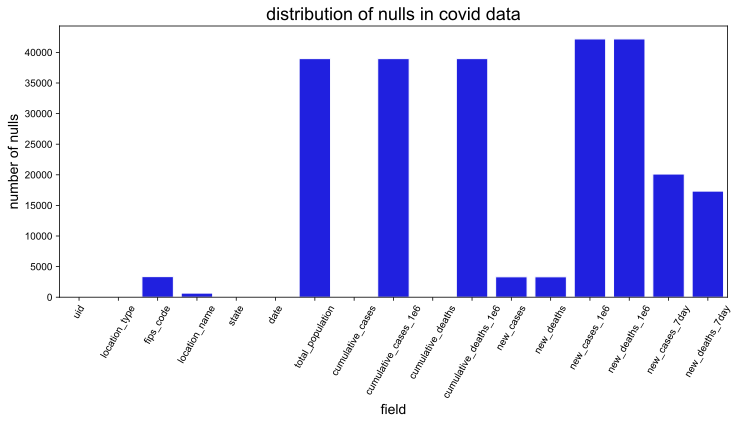

In [5]:
nulls = df.apply(lambda x: x.isnull().value_counts()).loc[True]

fig, ax = plt.subplots(figsize=[12, 5])
sns.set_style('darkgrid')
sns.barplot(x=nulls.index, y=nulls.values, ax=ax, color='b')
plt.xticks(rotation=60)
ax.set_ylabel("number of nulls", fontsize=MED_TEXT)
ax.set_xlabel("field", fontsize=MED_TEXT)
ax.set_title("distribution of nulls in covid data", fontsize=BIG_TEXT);

Write a function to check for nulls, datatypes, and sensible range of values. This will include an option to check all options, or to only check that all values are integers or check datatypes. 

In [6]:
def check_data(series, expect_type='int', check_all=True, check_ints=False, check_types=False, check_negs=True, name='Series'):
    """Check that the input array is of the expected datatype , and check for negative values
    
    Parameters
    ------------
    series: input pandas series
    expected_dtype: expected datatype for output message
    check_negs: boolean to check for negative values
    name: name of column for output
    """
    if check_ints: 
        all_ints = lambda ser: all([i.is_integer() for i in ser.values])
        print(f"all decimal components zero? (expect true) {all_ints(series)}")
        return 
    
    if check_types: 
        types = lambda ser: set([type(i) for i in ser.values])
        print(f"datatypes (expect {expect_type}): {types(series)}")
        return 
    
    if check_all: 
        all_ints = lambda ser: all([i.is_integer() for i in ser.values])
        print(f"checking {name}:")
        
        types = set([type(i) for i in series.values])
        print(f"datatypes (expect {expect_type}): {types}")

        nulls = series.isnull().sum()
        print(f"number of nulls: {nulls}")

        if check_negs: 
            num_negative = (series.values < 0).sum()
            print(f"number of negative values: {num_negative}")
        print("=================================================\n")
        


**uid**

In [7]:
check_data(df['uid'], "int", name='uid')

checking uid:
datatypes (expect int): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**location_type**


In [8]:
check_data(df['location_type'], "string", name="location_type", check_negs=False)

checking location_type:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



get a list of all the location types to see if we might want to throw anything out

In [9]:
loc_types = df['location_type'].unique()
print(loc_types)

['county' 'special_exception' 'out_of_state'
 'count_unassigned_to_location']


drop all records that don't have the location type of "county"

In [10]:
df = df.drop(df[~df['location_type'].isin(['county'])].index)
loc_types = df['location_type'].unique()
print(loc_types)

['county']


**fips_code**

In [11]:
check_data(df['fips_code'], "int", name="fips_code")

checking fips_code:
datatypes (expect int): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



These appear to be stored as floats, but it seems unecessary since these codes are only supposed to be whole numbers. 

Are there any fractional fips codes in this set? If not we can cast the series to integers

In [12]:
check_data(df['fips_code'], check_ints=True)

all decimal components zero? (expect true) True


Convert all fips codes to integers

In [13]:
df['fips_code'] = df['fips_code'].astype(np.int64)
check_data(df['fips_code'], "int", check_types=True)

datatypes (expect int): {<class 'numpy.int64'>}


**location_name**
Since we're only dealing with counties, let's change 'location_name' to county

In [14]:
df.rename(columns={'location_name': 'county'}, inplace=True)
check_data(df['county'], "string", name="county", check_negs=False)

checking county:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Later in this notebook, we will want to examine the county-level distribution of nulls in some counties. To avoid mis-counting due to multiple counties with the same name (e.g. North Carolina and Virginia both have a Mecklenburg county) we can create a new column to concatenate county and state. 

In [15]:
df['full_loc_name'] = df['county'] + ', ' + df['state']
check_data(df['full_loc_name'], "string", name="full_loc_name", check_negs=False)

checking full_loc_name:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Convert all to lower case - this is to avoid any case mis-matches when referring to the county name in the case / death dataset and policy dataset. 

In [16]:
df['county'] = df['county'].str.lower()

**state**

In [17]:
check_data(df['state'], "string", name="state", check_negs=False)

checking state:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



For this project, we're only considering the 50 states. Are there any territories in this set?

In [18]:
len(df['state'].unique())

52

In [19]:
df['state'].unique()

array(['Puerto Rico', 'Alabama', 'Alaska', 'Arizona', 'Arkansas',
       'California', 'Colorado', 'Connecticut', 'Delaware',
       'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
       'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
       'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
       'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
       'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

Let's remove Puerto Rico and Washington DC

In [20]:
df.drop(df[df['state'].isin(['Puerto Rico', 'District of Columbia'])].index, inplace=True)
len(df['state'].unique())

50

**date**

In [21]:
check_data(df['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'str'>}
number of nulls: 0



These dates are stored as strings instead of datetime objects, so lets convert them 

In [22]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

In [23]:
check_data(df['date'], "datetime", check_types="True")

datatypes (expect datetime): {<class 'numpy.datetime64'>}


Check that we have the proper range of dates

In [24]:
min(df['date'])

Timestamp('2020-01-22 00:00:00')

In [25]:
max(df['date'])

Timestamp('2020-12-22 00:00:00')

**total_population**

In [26]:
check_data(df['total_population'], "integer", name="total_population")

checking total_population:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



It doesn't make sense for the total population to be a fractional number, so convert these to integers. So, we'll check that all the values are integers (i.e. end in .0) then convert

In [27]:
check_data(df['total_population'], check_ints=True)

all decimal components zero? (expect true) True


In [28]:
df['total_population'] = df['total_population'].astype(np.int64)
check_data(df['total_population'], "integer", check_types=True)

datatypes (expect integer): {<class 'numpy.int64'>}


**cumulative_cases**

In [29]:
check_data(df['cumulative_cases'], "integer", name="cumulative_cases")

checking cumulative_cases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**cumulative_cases_1e6**

In [30]:
check_data(df['cumulative_cases_1e6'], "float", name="cumulative_cases_1e6")

checking cumulative_cases_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



**cumulative_deaths**

In [31]:
check_data(df['cumulative_deaths'], "integer", name="cumulative_deaths")

checking cumulative_deaths:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**cumulative_deaths_1e6**

In [32]:
check_data(df['cumulative_deaths_1e6'], "float", name="cumulative_deaths_1e6")

checking cumulative_deaths_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



**new_cases and new_deaths** 

For the sake of brevity, we'll look at new_cases and new_deaths at the same time

In [33]:
check_data(df['new_cases'], "integer", name="new_cases")
check_data(df['new_deaths'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3141
number of negative values: 12330

checking new_deaths:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 3141
number of negative values: 3158



Is there a particular pattern to where these NaNs and negative numbers are located?

In [34]:
num_states_case_negative    = len(df['state'][df['new_cases' ]   <0    ].unique())
num_states_death_negative   = len(df['state'][df['new_deaths']   <0    ].unique())
num_states_case_null        = len(df['state'][df['new_cases' ].isnull()].unique())
num_states_death_null       = len(df['state'][df['new_deaths'].isnull()].unique())

num_counties_case_negative  = len(df['full_loc_name'][df['new_cases' ]   <0    ].unique())
num_counties_death_negative = len(df['full_loc_name'][df['new_deaths']   <0    ].unique())
num_counties_case_null      = len(df['full_loc_name'][df['new_cases' ].isnull()].unique())
num_counties_death_null     = len(df['full_loc_name'][df['new_deaths'].isnull()].unique())

neg_county_case_ratio       = num_counties_case_negative  / len(df['full_loc_name'].unique())*100
neg_county_death_ratio      = num_counties_death_negative / len(df['full_loc_name'].unique())*100
null_county_case_ratio      = num_counties_case_null      / len(df['full_loc_name'].unique())*100
null_county_death_ratio     = num_counties_death_null     / len(df['full_loc_name'].unique())*100

arrays = [['negative', 'negative', 'null', 'null'], ['# states', '% counties', '# states', '% counties']]
tuples = list(zip(*arrays))
cols = pd.MultiIndex.from_tuples(tuples, names=['type', 'level'])

index = ['cases', 'deaths']

data = [
    [num_states_case_negative, neg_county_case_ratio, num_states_case_null, null_county_case_ratio],
    [num_states_death_negative, neg_county_death_ratio, num_states_death_null, null_county_death_ratio]
]

invalids = pd.DataFrame(data=data, index=index, columns=cols)
invalids

type   negative                null           
level  # states % counties # states % counties
cases        50  84.972939       50      100.0
deaths       50  43.393824       50      100.0

For both new cases and new deaths, most states have recorded a negative value and **all** counties have nulls. 

On what dates did these null values occur? 

In [35]:
dates_null_cases  = df['date'][df['new_cases'].isnull()].value_counts()
dates_null_deaths = df['date'][df['new_deaths'].isnull()].value_counts()

print(f"dates for new cases: \n{dates_null_cases}\n")
print(f"dates for new deaths: \n{dates_null_deaths}\n")

dates for new cases: 
2020-01-22    3141
Name: date, dtype: int64

dates for new deaths: 
2020-01-22    3141
Name: date, dtype: int64



Every instance of a null in new_cases and new_deaths occur on the first day that data was collected, so we can simply set those to zero

In [36]:
df.fillna(value={'new_cases': 0, 'new_deaths': 0}, inplace=True)

Now, let's investigate where these new_cases and new_deaths are negative. In the end, these negatives will be set to zero. This is justified by nickyforester's comment 0n the [disucssion page](https://data.world/associatedpress/johns-hopkins-coronavirus-case-tracker/discuss/johns-hopkins-coronavirus-case-tracker/zimsf5ki) for this dataset: 

>We calculate the new_cases and new_deaths columns as the difference in the cumulative count from the previous day. Discrepancies do sometimes appear in the Johns Hopkins data where cumulative counts decrease from one day to the next. This can happen if state or local governments adjust their historical data.
Johns Hopkins works to fix these inconsistencies in their data. When they do, the timeseries won't show a decreasing cumulative count. Decreases in the cumulative count — or negative new case/death counts — should be treated as errors/inconsistencies, not as a correction from Johns Hopkins.

Before we set these values to zero, let's investigate how these negatives are distributed and see if there's a pattern. 

In [37]:
neg_cases  = df[df['new_cases' ]<0]
neg_deaths = df[df['new_deaths']<0]

In [38]:
neg_cases.head()

,uid,location_type,fips_code,county,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
28874,84001011,county,1011,bullock,Alabama,2020-12-01,10352,701,6771.64,19,183.54,-1.0,0.0,-9.66,0.0,2.00,0.00,"Bullock, Alabama"
29224,84001013,county,1013,butler,Alabama,2020-12-15,20025,1332,6651.69,44,219.73,-8.0,0.0,-39.95,0.0,13.83,0.29,"Butler, Alabama"
31219,84001025,county,1025,clarke,Alabama,2020-11-24,24387,1553,6368.15,19,77.91,-1.0,0.0,-4.10,0.0,7.83,0.00,"Clarke, Alabama"
31543,84001027,county,1027,clay,Alabama,2020-11-12,13378,825,6166.84,13,97.17,-1.0,0.0,-7.47,0.0,3.33,0.00,"Clay, Alabama"
46030,84001113,county,1113,russell,Alabama,2020-12-21,58213,2594,4456.05,6,10.31,-1.0,0.0,-1.72,0.0,20.83,0.00,"Russell, Alabama"


In [39]:
neg_deaths.head()

,uid,location_type,fips_code,county,state,date,total_population,cumulative_cases,cumulative_cases_1e6,cumulative_deaths,cumulative_deaths_1e6,new_cases,new_deaths,new_cases_1e6,new_deaths_1e6,new_cases_7day,new_deaths_7day,full_loc_name
26969,84001001,county,1001,autauga,Alabama,2020-04-20,55200,28,50.72,1,1.81,2.0,-1.0,3.62,-1.81,1.29,0.17,"Autauga, Alabama"
26980,84001001,county,1001,autauga,Alabama,2020-05-01,55200,43,77.90,3,5.43,1.0,-1.0,1.81,-1.81,1.00,0.33,"Autauga, Alabama"
26999,84001001,county,1001,autauga,Alabama,2020-05-20,55200,135,244.57,3,5.43,5.0,-1.0,9.06,-1.81,6.43,0.00,"Autauga, Alabama"
27134,84001001,county,1001,autauga,Alabama,2020-10-02,55200,1812,3282.61,27,48.91,13.0,-1.0,23.55,-1.81,8.86,0.50,"Autauga, Alabama"
27169,84001001,county,1001,autauga,Alabama,2020-11-06,55200,2257,4088.77,30,54.35,13.0,-1.0,23.55,-1.81,14.71,0.00,"Autauga, Alabama"


On cursory inpection, there doesn't seem to be a particular pattern. Let's try visualizing how these values are distributed among the states. 

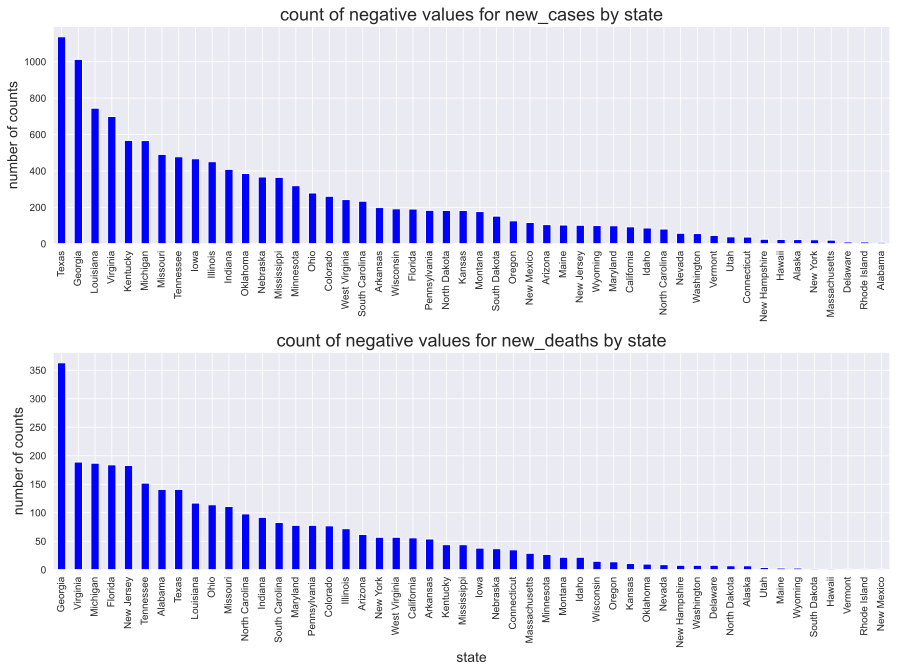

In [40]:
fig, ax = plt.subplots(nrows=2, figsize=[15,10])

plt.subplots_adjust(hspace=0.5)
neg_cases['state'].value_counts().plot.bar(ax=ax[0], color='b')
neg_deaths['state'].value_counts().plot.bar(ax=ax[1], color='b')

ax[0].set_title("count of negative values for new_cases by state", fontsize=BIG_TEXT)
ax[0].set_ylabel("number of counts", fontsize=MED_TEXT)

ax[1].set_title("count of negative values for new_deaths by state", fontsize=BIG_TEXT)
ax[1].set_xlabel("state", fontsize=MED_TEXT)
ax[1].set_ylabel("number of counts", fontsize=MED_TEXT);

Aside from Georgia on the new_deaths plot, no single state is giving an overwhelmingly large contribution to the negative values for new_deaths, but there is a clear distribution.

How many negative values are present for any given day? Are there a few days that reported lots of negative values or are they evenly distributed?  

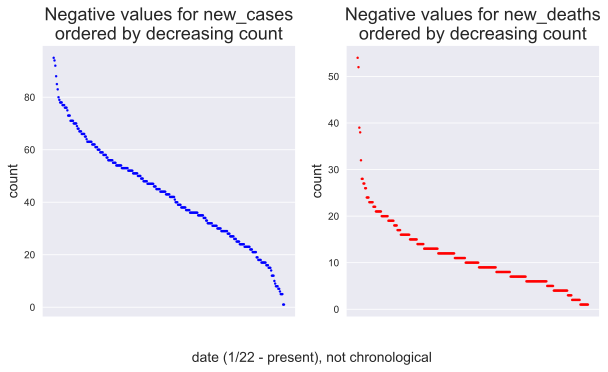

In [41]:
date_case_counts = neg_cases['date'].value_counts()
date_death_counts = neg_deaths['date'].value_counts()

fig, ax = plt.subplots(ncols=2, figsize=[10,5])

sns.scatterplot(x=date_case_counts.index.strftime(date_format='%Y-%m-%d'), 
                y=date_case_counts, 
                ax=ax[0], 
                edgecolor=None, 
                s=5,
                color='b')


sns.scatterplot(x=date_death_counts.index.strftime(date_format='%Y-%m-%d'), 
                y=date_death_counts, 
                ax=ax[1], 
                edgecolor=None,
                s=5, 
                color='r')

ax[0].set_ylabel("count", fontsize=MED_TEXT)
ax[0].set(xticklabels=[])
ax[0].grid(axis='x')
ax[0].set_title("Negative values for new_cases\nordered by decreasing count", fontsize=BIG_TEXT)
ax[1].set_ylabel("count", fontsize=MED_TEXT)
ax[1].set(xticklabels=[])
ax[1].grid(axis='x')
ax[1].set_title("Negative values for new_deaths\nordered by decreasing count", fontsize=BIG_TEXT)
fig.text(0.5, 0, 'date (1/22 - present), not chronological', ha='center', fontsize=MED_TEXT);

It appears that a few dates have many negative values (especially in new_deaths) while most dates have 20-40 negatives in new_cases and 5-20 negatives in new_deaths. 

How are these negatives distributed over time? 

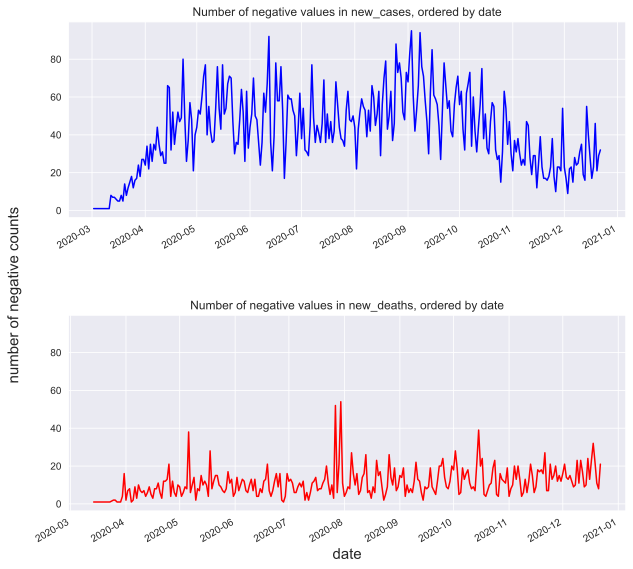

In [42]:
date_case_counts = neg_cases['date'].value_counts()
date_death_counts = neg_deaths['date'].value_counts()

fig, ax = plt.subplots(nrows=2, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)

date_case_counts.sort_index().plot.line(ax=ax[0], color='b')
date_death_counts.sort_index().plot.line(ax=ax[1], color='r')

ax[0].set_title("Number of negative values in new_cases, ordered by date")
ax[1].set_title("Number of negative values in new_deaths, ordered by date")


fig.text(0.04, 0.5, 'number of negative counts', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

These spikes in negative numbers appear to occur on a weekly basis. The number of negative values reported in new_cases has been graduallly decreasing since September.

negative values in new_deaths seem to peak in late September. Other than that, they seem to be relatively constant

What days of the week see the most negative values in new_deaths and new_cases? 

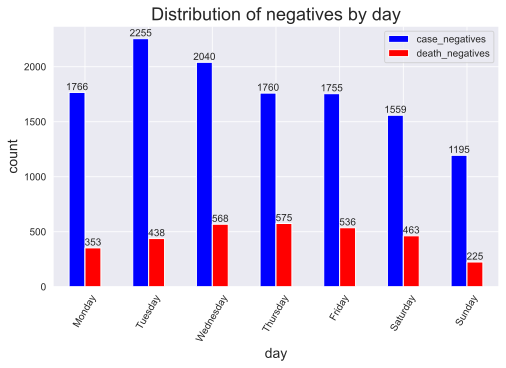

In [43]:
days = {
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday', 
    5: 'Saturday', 
    6: 'Sunday'
}
    
negative_data = {'day': [days[i] for i in range(0, 7)], 
                 'case_negatives': [sum(neg_cases['new_cases'][neg_cases['date'].dt.dayofweek==day].value_counts()) 
                                    for day in range(0, 7)],
                 'death_negatives': [sum(neg_deaths['new_deaths'][neg_deaths['date'].dt.dayofweek==day].value_counts()) 
                                    for day in range(0, 7)]}



negatives_by_day = pd.DataFrame(data=negative_data, columns=['case_negatives', 'death_negatives'], index=negative_data['day'])

fig, ax = plt.subplots(figsize=[8, 4.8])
negatives_by_day.plot.bar(ax=ax, color=['b', 'r'])
ax.set_title("Distribution of negatives by day", fontsize=BIG_TEXT)
ax.set_ylabel("count", fontsize=MED_TEXT)
ax.set_xlabel("day", fontsize=MED_TEXT)
for p in ax.patches: 
    ax.annotate(np.round(p.get_height(),decimals=2),                             
               (p.get_x()+p.get_width()/2., p.get_height()),   
                fontsize=SMALL_TEXT,
                ha='center',                              
                va='center',                              
                xytext=(0, 5),                               
                textcoords='offset points')
plt.xticks(rotation=60);

Code for bar labels taken from [leroygr's solution](https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots) on stackoverflow. 

Most negatives in new_cases appear on Tuesdays and most of the negatives on new deaths appear on Wednesdays, but not by a particularly large margin on cursory inspection. 

Now we examine the actual values. Are all these on the order of -1 or -2 or are there any larger values involved? 

In [44]:
case_values = neg_cases['new_cases'].value_counts()
death_values = neg_deaths['new_deaths'].value_counts()

print(f"value counts for invalid cases\n{case_values.head()}\n")
print(f"value counts for invalid deaths\n{death_values.head()}\n")

value counts for invalid cases
-1.0    8511
-2.0    1657
-3.0     605
-4.0     311
-5.0     226
Name: new_cases, dtype: int64

value counts for invalid deaths
-1.0    2637
-2.0     252
-3.0      81
-4.0      59
-5.0      37
Name: new_deaths, dtype: int64



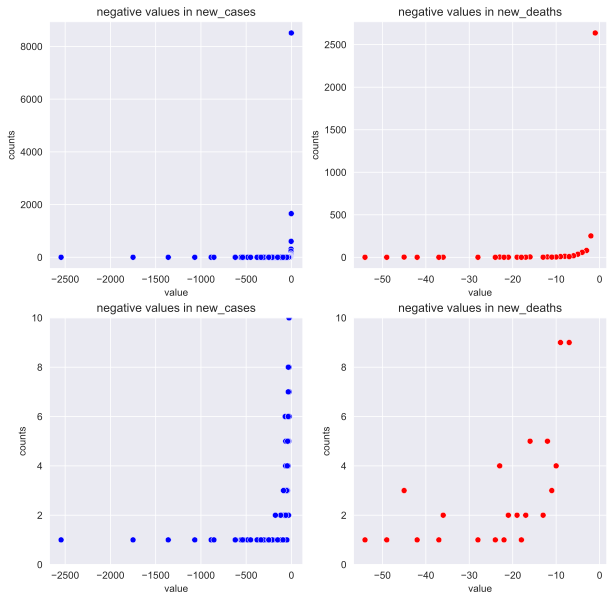

In [45]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=([10,10]))

for i in [0,1]:
    sns.scatterplot(x=neg_cases['new_cases'].value_counts().index, 
                    y=neg_cases['new_cases'].value_counts().values, 
                    color='b', 
                    ax=ax[i][0])
    sns.scatterplot(x=neg_deaths['new_deaths'].value_counts().index, 
                    y=neg_deaths['new_deaths'].value_counts().values, 
                    color='r', 
                    ax=ax[i][1])

    ax[i][0].set_title("negative values in new_cases")
    ax[i][0].set_ylabel("counts")
    ax[i][0].set_xlabel("value")
    ax[i][1].set_title("negative values in new_deaths")
    ax[i][1].set_ylabel("counts")
    ax[i][1].set_xlabel("value"); 
ax[1][0].set_ylim([0, 10]);
ax[1][1].set_ylim([0, 10]);

As expected, the vast majority are only at -1 or -2 for both new_cases and new_deaths. However, there are a few instances of particularly large negative values which have the potential to influence future modeling. 
 
For the sake of curiosity, let's look at which states and counties are the biggest culprits for these values. We're only interested in large negative values, which we'll call <-100 for cases and <-10 for deaths.  

Where are these large negative values occuring? 

In [46]:
neg_cases[['full_loc_name', 'date', 'new_cases']][neg_cases['new_cases']<-100].sort_values(by='new_cases').head(10)

,full_loc_name,date,new_cases
879557,"Bexar, Texas",2020-09-23,-2545.0
150513,"Orange, Florida",2020-12-08,-1750.0
205252,"Union, Georgia",2020-11-09,-1361.0
874848,"Anderson, Texas",2020-09-18,-1068.0
171315,"Decatur, Georgia",2020-11-08,-887.0
1070734,"Sheboygan, Wisconsin",2020-09-16,-856.0
101326,"San Bernardino, California",2020-07-30,-621.0
796645,"Montour, Pennsylvania",2020-12-12,-620.0
625787,"Hudson, New Jersey",2020-06-25,-558.0
1070063,"Sawyer, Wisconsin",2020-09-17,-540.0


In [47]:
neg_deaths[['full_loc_name', 'date', 'new_deaths']][neg_deaths['new_deaths']<-10].sort_values(by='new_deaths').head(10)

,full_loc_name,date,new_deaths
796101,"Montgomery, Pennsylvania",2020-05-18,-54.0
948412,"Tarrant, Texas",2020-08-29,-49.0
625727,"Hudson, New Jersey",2020-04-26,-45.0
893756,"Dallas, Texas",2020-12-19,-45.0
648976,"Kings, New York",2020-06-30,-45.0
788373,"Delaware, Pennsylvania",2020-05-18,-42.0
950731,"Travis, Texas",2020-07-27,-37.0
792709,"Lancaster, Pennsylvania",2020-04-16,-36.0
101714,"San Diego, California",2020-09-20,-36.0
796773,"Northampton, Pennsylvania",2020-05-18,-28.0


From this, we see that Bexas County, Texas and Hudson County, New Jersey are responsible for the largest negative values. In a future version of this project, we'll continue to examine what's going on with these negative values. For now, we will set these to zero and move on. 

In [48]:
df['new_cases' ].clip(lower=0, inplace=True)
df['new_deaths'].clip(lower=0, inplace=True)

In [49]:
df['full_loc_name'][df['new_cases_7day'].isnull()].value_counts()

West Feliciana, Louisiana    48
Jones, Texas                 46
Richmond, Virginia           46
Cameron, Louisiana           38
St. Helena, Louisiana        29
                             ..
Koochiching, Minnesota        5
Lake, Colorado                5
Taylor, Georgia               5
Fulton, Illinois              5
Floyd, Texas                  5
Name: full_loc_name, Length: 3141, dtype: int64

Finally, cast everything to integers- first checking that all new case numbers are whole numbers

In [50]:
print(f"new_cases: ")
check_data(df['new_cases'], check_ints=True)

print(f"\nnew_deaths: ")
check_data(df['new_deaths'], check_ints=True)

new_cases: 
all decimal components zero? (expect true) True

new_deaths: 
all decimal components zero? (expect true) True


In [51]:
df['new_cases'] = df['new_cases'].astype(np.int64)
df['new_deaths'] = df['new_deaths'].astype(np.int64)

check_data(df['new_cases'], "integer", name="new_cases")
check_data(df['new_deaths'], "integer", name="new_deaths")

checking new_cases:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**new_cases_1e6, new_deaths_1e6**

In [52]:
check_data(df['new_cases_1e6' ], "float", name="new_cases" )
check_data(df['new_deaths_1e6'], "float", name="new_deaths")

checking new_cases:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 3141
number of negative values: 12330

checking new_deaths:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 3141
number of negative values: 3158



This set has the exact same number of nulls and negative values as new_cases and new_deaths, which makes sense since these are calculated fields based on new_cases and new_deaths. Therefore we can apply the exact same treatment.

In [53]:
df['new_cases_1e6' ].clip(  lower=0, inplace=True)
df['new_cases_1e6' ].fillna(value=0, inplace=True)
df['new_deaths_1e6'].clip(  lower=0, inplace=True)
df['new_deaths_1e6'].fillna(value=0, inplace=True)

check_data(df['new_cases_1e6' ], "float", name="new_cases" )
check_data(df['new_deaths_1e6'], "float", name="new_deaths")

checking new_cases:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



**new_cases_7day & new_deaths_7day**



In [54]:
check_data(df['new_cases_7day' ], "integer", name="new_cases_7day")
check_data(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 16736
number of negative values: 0

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 15768
number of negative values: 0



new_cases_7day and new_deaths_7day have many more nulls than the previous 4 columns. The most likely case is that the 7 day rolling averages are null in the first 6 days of data collection since there weren't enough values to calculate an average. 

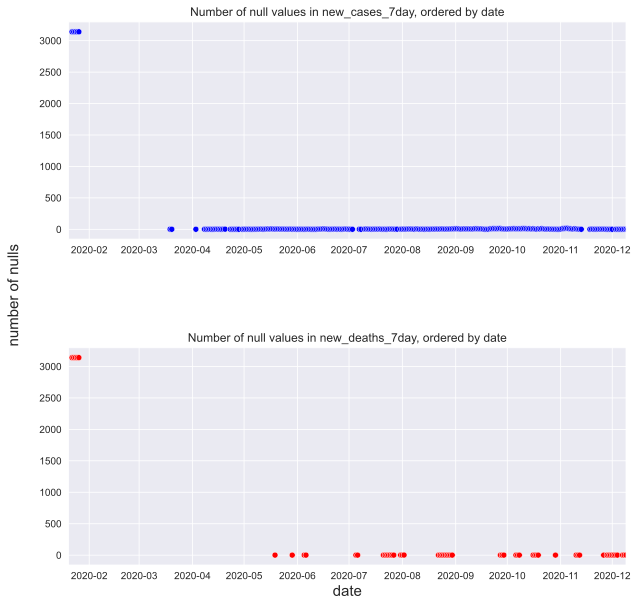

In [55]:
null_case_7day_counts=df['date'][df['new_cases_7day'].isnull()].value_counts().sort_index()
null_death_7day_counts=df['date'][df['new_deaths_7day'].isnull()].value_counts().sort_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)


sns.scatterplot(x=null_case_7day_counts.index, 
                y=null_case_7day_counts.values, 
                color='b', 
                ax=ax[0])
sns.scatterplot(x=null_death_7day_counts.index, 
                y=null_death_7day_counts.values,  
                color='r', 
                ax=ax[1])
ax[0].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.to_datetime('2020-12-09', format='%Y-%m-%d')])
ax[1].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.to_datetime('2020-12-09', format='%Y-%m-%d')])

ax[0].set_title("Number of null values in new_cases_7day, ordered by date")
ax[1].set_title("Number of null values in new_deaths_7day, ordered by date")





fig.text(0.04, 0.5, 'number of nulls', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

As expected, the vast majority of these nulls appear to occur in the first few days, so we'll set these to zero

In [56]:
df[['new_cases_7day', 'new_deaths_7day']] = df[['new_cases_7day', 'new_deaths_7day']].mask(
    (df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')), df[['new_cases_7day', 'new_deaths_7day']].fillna(0))

In [57]:
check_data(df['new_cases_7day' ], "integer", name="new_cases_7day" )
check_data(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 1031
number of negative values: 0

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 63
number of negative values: 0



There are still some nulls present in the dataset. 

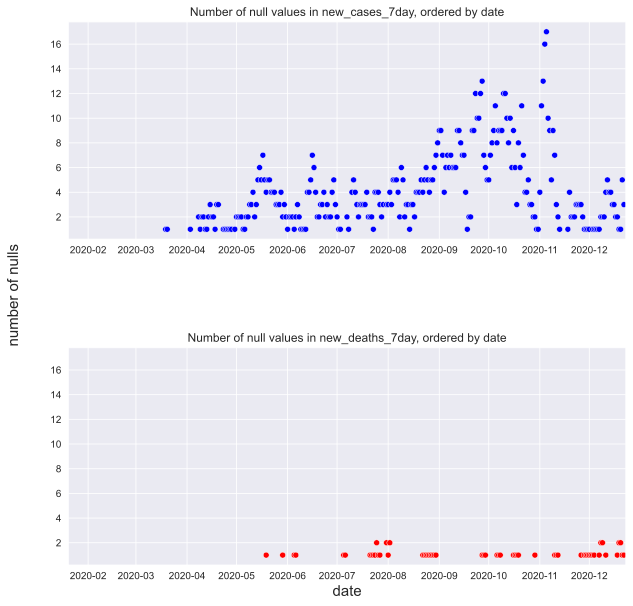

In [58]:
null_case_7day_counts=df['date'][df['new_cases_7day'].isnull()].value_counts().sort_index()
null_death_7day_counts=df['date'][df['new_deaths_7day'].isnull()].value_counts().sort_index()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=[10, 10], sharey=True)
plt.subplots_adjust(hspace=0.5)


sns.scatterplot(x=null_case_7day_counts.index, 
                y=null_case_7day_counts.values, 
                color='b', 
                ax=ax[0])
sns.scatterplot(x=null_death_7day_counts.index, 
                y=null_death_7day_counts.values,  
                color='r', 
                ax=ax[1])
ax[0].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.Timestamp.today()])
ax[1].set_xlim([pd.to_datetime('2020-01-20', format='%Y-%m-%d'), pd.Timestamp.today()])

ax[0].set_title("Number of null values in new_cases_7day, ordered by date")
ax[1].set_title("Number of null values in new_deaths_7day, ordered by date")





fig.text(0.04, 0.5, 'number of nulls', va='center', rotation='vertical', fontsize=15)
ax[1].set_xlabel("date", fontsize=15); 

In [59]:
df['full_loc_name'][df['new_cases_7day'].isnull()].value_counts()

West Feliciana, Louisiana          43
Jones, Texas                       41
Richmond, Virginia                 41
Cameron, Louisiana                 33
St. Helena, Louisiana              24
                                   ..
Jones, Georgia                      1
Washington, Maryland                1
Lauderdale, Tennessee               1
Sussex, New Jersey                  1
St. John the Baptist, Louisiana     1
Name: full_loc_name, Length: 210, dtype: int64

Since there are still some nulls in these series, let's re-calculate the 7 day rolling average at these dates

In [60]:
nulls_case7day  = df[df['new_cases_7day' ].isnull()]
nulls_death7day = df[df['new_deaths_7day'].isnull()]
days_7   = timedelta(days=7)

i        = 0
num_elem = len(nulls_case7day)

msg      = "Looping through nulls in new_cases_7day. Please be patient, this may take a while"
print(msg)

for index, data in nulls_case7day.iterrows():
    i+=1
    if i%10==0: 
        print(f"index: {i}/{num_elem}")
    if i%250==0: 
        clear_output()
        print(msg)
        print(f"index: {i}/{num_elem}")
        
    df.loc[index, ['new_cases_7day']] = np.sum(([df['new_cases'][
        (df['full_loc_name']==data.full_loc_name) & 
        ((df['date']<=data.date) & (df['date']>data.date-days_7))
    ].values]))/7
    
clear_output()
print("Looping through nulls in new_deaths_7day. Please be patient, this may take a while")

i        = 0
num_elem = len(nulls_death7day)

for index, data in nulls_death7day.iterrows():
    i+=1
    if i%10==0: 
        print(f"index: {i}/{num_elem}")
        
    df.loc[index, ['new_deaths_7day']] = np.sum(([df['new_deaths'][
        (df['full_loc_name']==data.full_loc_name) & 
        ((df['date']<=data.date) & (df['date']>data.date-days_7))
    ].values]))/7

clear_output()
print("done :)")

done :)


In [61]:
check_data(df['new_cases_7day' ], "integer", name="new_cases_7day" )
check_data(df['new_deaths_7day'], "integer", name="new_deaths_7day")

checking new_cases_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths_7day:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



**new_cases_7day_1e6 & new_deaths_7day_1e6**

Create a new calculated field with the normalized 7 day running averages

In [62]:
df["new_cases_7day_1e6" ] = df['new_cases_7day' ] / (df['total_population']/1e5)
df["new_deaths_7day_1e6"] = df['new_deaths_7day'] / (df['total_population']/1e5)

check_data(df['new_cases_7day_1e6' ], "float", name="new_cases_7day_1e6" )
check_data(df['new_deaths_7day_1e6'], "float", name="new_deaths_7day_1e6")

checking new_cases_7day_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0

checking new_deaths_7day_1e6:
datatypes (expect float): {<class 'numpy.float64'>}
number of nulls: 0
number of negative values: 0



# Policy Data

Load a dataset which categorizes the various covid-19 responses throughout the country. At the moment, this is a static csv file stored locally. In a future update, I'll make a live connection to the data source.

source: https://healthdata.gov/dataset/covid-19-state-and-county-policy-orders

In [63]:
df2 = pd.read_csv('state_policy_updates_20201114_0719.csv')
df2.head()

,state_id,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,NY,Bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,NaN
1,DE,NaN,NaN,state,2020-03-27,Modify Medicaid Requirements With 1135 Waivers...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
2,FL,NaN,NaN,state,2020-03-18,Allow Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
3,MI,Delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,NaN
4,NE,Box Butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,NaN


column-wise evaluation

In [64]:
eval_df(df2)

field           num_nulls  datatypes
------------  -----------  --------------------------------
state_id                0  {<class 'str'>}
county               1646  {<class 'float'>, <class 'str'>}
fips_code            1646  {<class 'numpy.float64'>}
policy_level            0  {<class 'str'>}
date                    0  {<class 'str'>}
policy_type             0  {<class 'str'>}
start_stop              0  {<class 'str'>}
comments                0  {<class 'str'>}
source                  0  {<class 'str'>}
total_phases         2819  {<class 'numpy.float64'>}


**state_id**

In [65]:
check_data(df2['state_id'], "string", name="state_id", check_negs=False)

checking state_id:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



Check which states / territories are in this dataset. 

In [66]:
df2['state_id'].unique()

array(['NY', 'DE', 'FL', 'MI', 'NE', 'MS', 'HI', 'IN', 'AR', 'MO', 'RI',
       'ID', 'TX', 'NJ', 'ND', 'NV', 'CA', 'PA', 'AZ', 'KS', 'WA', 'WI',
       'OH', 'MT', 'VT', 'IL', 'MA', 'WV', 'LA', 'ME', 'CT', 'MP', 'AK',
       'UT', 'IA', 'GU', 'DC', 'OK', 'CO', 'SC', 'KY', 'NC', 'MN', 'TN',
       'NM', 'OR', 'GA', 'SD', 'NH', 'VA', 'WY', 'MD', 'AL', 'PR', 'VI'],
      dtype=object)

To make this column compatable with 'state' in the case / death dataset, we'll do the following:

- convert ID's to full names

- restrict to the 50 states

- rename the column to 'state'

In [67]:
abbr = [elem.abbr for elem in us.states.STATES]
df2 = df2.drop(df2[~df2['state_id'].isin(abbr)].index)
df2.replace(to_replace=us.states.mapping('abbr', 'name'), inplace=True)
df2.rename(columns={'state_id': 'state'}, inplace=True)

In [68]:
df2.head()

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases
0,New York,Bronx,36005.0,county,2020-06-08,Non-Essential Businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...,NaN
1,Delaware,NaN,NaN,state,2020-03-27,Modify Medicaid Requirements With 1135 Waivers...,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
2,Florida,NaN,NaN,state,2020-03-18,Allow Expand Medicaid Telehealth Coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database,NaN
3,Michigan,Delta,26041.0,county,2020-07-31,Entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...,NaN
4,Nebraska,Box Butte,31013.0,county,2020-03-30,Shelter in Place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual,NaN


**county**

In [69]:
check_data(df2['county'], "string", name="county", check_negs=False)

checking county:
datatypes (expect string): {<class 'float'>, <class 'str'>}
number of nulls: 1578



Nulls in the county field likely refer to statewide policies. Let's verify that there aren't any counties with 'null' that aren't statewide policies.  

In [70]:
df2[(df2['county'].isnull()) & (df2['policy_level']!='state')]

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases


We can safely convert these nulls to 'statewide', then convert all county names to lowercase

In [71]:
df2.fillna(value={'county': 'statewide'}, inplace=True)
df2['county'] = df2['county'].str.lower()

Check that all the counties in df2 are also present in df

In [72]:
locs = df['county'].unique()
mismatches = [county for county in df2['county'][df2['county']!='statewide'].unique() 
              if county not in locs]
print(mismatches)

['frio county', 'osage county', 'colusa county', 'erie county', 'greene county', 'aransas county', 'starr county', 'wichita county', 'shawnee county', 'lafayette county', 'anderson county', 'hardin county', 'orange county', 'gadsden county', 'castro county', 'andrews county', 'jefferson county', 'summit county', 'lehigh county', 'dougherty county', 'marion county', 'saline county', 'brown county', 'coryell county', 'montgomery county', 'henderson county', 'angelina county', 'warren county', 'dane county', 'galveston county', 'floyd county', 'willacy county', 'platte county', 'maui county', 'san patricio county', 'crawford county', 'milam county', 'bee county', 'collin county', 'stanislaus county', 'newton county', 'iron county', 'clayton county', 'mendocino county', 'forest county', 'westmoreland county', 'skagway municipality', 'arapahoe county', 'fort bend county', 'riverside county', 'adams county', 'kleberg county', 'hidalgo county', 'san jacinto county', 'deaf smith county', 'sono

There are some slight differences in location names. For example, frio county in the policy dataset is written as frio in the case dataset. Remove the modifiers at the end of the location names so they match the case dataset.

In [73]:
county_match    = re.compile(" county$")
munici_match    = re.compile(" municipality$")
city_match      = re.compile(" city$")
Borough_match   = re.compile(" borough$")

df2['county'].replace(to_replace= county_match, value='', inplace=True)
df2['county'].replace(to_replace= munici_match, value='', inplace=True)
df2['county'].replace(to_replace=   city_match, value='', inplace=True)
df2['county'].replace(to_replace=Borough_match, value='', inplace=True)

In [74]:
locs = df['county'].unique()
mismatches = [county for county in df2['county'][df2['county']!='statewide'].unique() 
              if county not in locs]
print(mismatches)

[]


In [75]:
check_data(df2['county'], "string", name="county", check_negs=False)

checking county:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**fips_code**

In [76]:
check_data(df2['fips_code'], "integer", name="fips_code")

checking fips_code:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 1578
number of negative values: 0



These nulls in fips_code should all refer to statewide polices- first check that there are no nulls in fips_code that are not concurrent with a statewide policy. 

In [77]:
df2[(df2['fips_code'].isnull()) & (df2['policy_level'] != 'state')]

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source,total_phases


All of these null values are statewide policies. Let's replace these nulls with the 2 digit fips code for the state

In [78]:
for index, data in df2.iterrows(): 
    if data.policy_level == 'state':
        df2.loc[index, 'fips_code'] = np.int64(us.states.lookup(data.state).fips)

Next, we'll ensure that all datapoints are integers then convert to ints

In [79]:
check_data(df2['fips_code'], check_ints=True)

all decimal components zero? (expect true) True


In [80]:
df2['fips_code'] = df2['fips_code'].astype(np.int64)
check_data(df2['fips_code'], "integer", name="fips_code")

checking fips_code:
datatypes (expect integer): {<class 'numpy.int64'>}
number of nulls: 0
number of negative values: 0



**policy_level**

In [81]:
check_data(df2['policy_level'], "string", name="policy_level", check_negs=False)

checking policy_level:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



In [82]:
df2['policy_level'].unique()

array(['county', 'state'], dtype=object)

**date**

In [83]:
check_data(df2['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'str'>}
number of nulls: 0



convert these dates to strings like in case_data

In [84]:
df2['date'] = pd.to_datetime(df2['date'], format='%Y-%m-%d')

Drop any policies that may have been implemented before the start of the case dataset.

In [85]:
df2 = df2.drop(df2[(df2['date']<min(df['date'])) | (df2['date']>datetime.today())].index)

In [86]:
check_data(df2['date'], "datetime", name="date", check_negs=False)

checking date:
datatypes (expect datetime): {<class 'numpy.datetime64'>}
number of nulls: 0



**policy_type**

In [87]:
check_data(df2['policy_type'], "string", name="policy_type", check_negs=False)

checking policy_type:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



We will depend on policy_type quite a bit later on, so let's investigate what kind of policies are in this dataset

In [88]:
print(np.sort((df2['policy_type'].unique())))

['Agriculture' 'Allow Audio Only Telehealth'
 'Allow Expand Medicaid Telehealth Coverage'
 'Alternative Care Facilities ' 'Bars' 'Childcare (K-12)'
 'Colleges & Universities' 'Construction' 'Day Care'
 'Day camps/overnight camps' 'Education' 'Election' 'Entertainment'
 'Executive Order' 'Food and Drink' 'Froze Mortgage Payments' 'Gatherings'
 'Graduation' 'Graduation Ceremony guidelines' 'Gyms' 'Health Risk Status'
 'Houses of Worship'
 'Mandate Face Mask Use By All Individuals In Public Facing Businesses'
 'Mandate Face Mask Use By All Individuals In Public Spaces'
 'Manufacturing' 'Mask Requirement' 'Medical'
 'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval'
 'New Phase' 'Non-Essential Businesses' 'Nursing Home Visitations'
 'Nursing Homes' 'Order Freezing Utility Shut Offs'
 'Outdoor and Recreation' 'Personal Care' 'Phase 1' 'Phase 2' 'Phase 2, 3'
 'Phase 3' 'Phase 3 Step 2' 'Phase 4' 'Phase 5' 'Public Gatherings'
 'Public Health Advisory System' 'Quarantine'
 '

Some of these names are a bit too long. Rename any policy type longer than 40 characters

In [89]:
long_names = [policy for policy in df2['policy_type'].unique() if len(policy)>40]
for i in long_names: 
    print(i)

Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval
Allow Expand Medicaid Telehealth Coverage
Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues
Mandate Face Mask Use By All Individuals In Public Spaces
Mandate Face Mask Use By All Individuals In Public Facing Businesses
Reopened ACA Enrollment Using a Special Enrollment Period
Suspended Elective Medical Dental Procedures
Stop Initiation Of Evictions Overall Or Due To Covid Related Issues
Renter Grace Period Or Use Of Security Deposit To Pay Rent


In [90]:
policy_replacements_dict = {
    'Stop Initiation Of Evictions Overall Or Due To Covid Related Issues': 'Stop Initiation Of Evictions',
    'Modify Medicaid Requirements With 1135 Waivers Date Of CMS Approval': 'Modify Medicaid Requirements', 
    'Stop Enforcement Of Evictions Overall Or Due To Covid Related Issues': 'Stop Enforcement Of Evictions', 
    'Mandate Face Mask Use By All Individuals In Public Facing Businesses':  'Mandate Face Masks In Businesses', 
    'Mandate Face Mask Use By All Individuals In Public Spaces': 'Mandate Face Masks In Public Spaces', 
    'Reopened ACA Enrollment Using a Special Enrollment Period': 'ACA Special Enrollment Period', 
    'Suspended Elective Medical Dental Procedures': 'Suspend Elective Dental Procedures', 
    'Allow Expand Medicaid Telehealth Coverage': 'Expand Medicaid Telehealth Coverage', 
    'Renter Grace Period Or Use Of Security Deposit To Pay Rent': 'Grace Period / Security Deposit for Rent'
}

for key in policy_replacements_dict.keys():
    df2['policy_type'].replace(to_replace=key, value=policy_replacements_dict[key], inplace=True)

long_names = [policy for policy in df2['policy_type'].unique() if len(policy)>40]
if len(long_names) == 0: 
    print("no more long names")

no more long names


Aditionally, let's convert everything to lowercase for consistency

In [91]:
df2['policy_type'] = df2['policy_type'].str.lower()

Some of these policies are also vague and non-specific, so we'll drop these as well 

In [92]:
policies_drop = ["phase 1", "phase 2", "phase 3", "phase 4", "phase 5", "new phase"]
df2 = df2.drop(df2[df2['policy_type'].isin(policies_drop)].index)

**start_stop**

In [93]:
check_data(df2['start_stop'], "string", name="start_stop", check_negs=False)

checking start_stop:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



In [94]:
df2['start_stop'].unique()

array(['start', 'stop'], dtype=object)

**comments**

In [95]:
check_data(df2['comments'], "string", name="comments", check_negs=False)

checking comments:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**source**

In [96]:
check_data(df2['source'], "string", name="source", check_negs=False)

checking source:
datatypes (expect string): {<class 'str'>}
number of nulls: 0



**total_phases**

In [97]:
check_data(df2['total_phases'], "integer", name="total_phases", check_negs=False)

checking total_phases:
datatypes (expect integer): {<class 'numpy.float64'>}
number of nulls: 2534



We likely won't be interested in total_phases at any point in this project, so let's drop it. 

In [98]:
df2.drop('total_phases', axis=1, inplace=True)

In [99]:
df2.head()

,state,county,fips_code,policy_level,date,policy_type,start_stop,comments,source
0,New York,bronx,36005,county,2020-06-08,non-essential businesses,start,"Policy_Details: Construction\r\nAgriculture, F...",sip_submission_form: https://coronavirus.healt...
1,Delaware,statewide,10,state,2020-03-27,modify medicaid requirements,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
2,Florida,statewide,12,state,2020-03-18,expand medicaid telehealth coverage,start,Other measures and details for this policy inc...,BU COVID-19 State Policy Database
3,Michigan,delta,26041,county,2020-07-31,entertainment,start,"Policy_Details: Region 8 indoor cinemas, conve...",sip_submission_form: https://www.michigan.gov/...
4,Nebraska,box butte,31013,county,2020-03-30,shelter in place,start,http://dhhs.ne.gov/Pages/COVID-19-Directed-Hea...,manual
